## CHEME 5660: Estimating Geometric Brownian Motion (GBM) Model Parameters from Data

### Introduction
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $X(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dX}{X} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process). 

#### Analytical solution
In the [lecture notes](https://varnerlab.github.io/CHEME-5660-Markets-Mayhem-Book/chapter-2-dir/stochastic-differential-equations.html#analytical-solution-geometric-brownian-motion) we used [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma) to formulate an analytical solution to the GBM equation:

$$X(t) = X_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})Z(0,1)\Biggr]$$

where $X_{\circ}$ denotes the initial price at $t_{\circ}$, and $Z(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution). 

#### Problem
Estimate the constant parameters $\mu$ and $\sigma$ that appear in the GBM solution from Open High Low Close (OHLC) price data. Let's explore the share price of the [Nasdaq ETF QQQ](https://finance.yahoo.com/quote/QQQ/).

### Lab setup
The code block below installs (and loads) any [Julia](https://julialang.org) packages that we need to complete the calculations. 

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-3-Calibration-GBM-Data`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-3-Calibration-GBM-Data/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-3-Calibration-GBM-Data/Manifest.toml`


In [2]:
using DataFrames
using CSV
using Distributions
using Statistics
using LinearAlgebra
using Plots
using StatsPlots
using Colors

### Load the lab 3 code library
The call to the `include` function loads the `CHEME-5660-Lab-3-Library.jl` library into the notebook; the library contains types and functions we use during the lab:

__Types__:
* `GeometricBrownianMotionModel` holds information about the GBM model simulation

__Functions__:
* `E(model::GeometricBrownianMotionModel) --> Array{Float64,2}` and `E(data::DataFrame, key::Symbol) --> Array{Float64,2}` compute the expectation of the share price from the model, and the OHLC data set, respectively. The first col of the array returned by the `E(...)` function holds the time, and the second col holds the data.
* `Var(model::GeometricBrownianMotionModel) --> Array{Float64,2}` and `Var(data::DataFrame, key::Symbol) --> Array{Float64,2}` compute the variance of the share price from the model, and the OHLC data set, respectively. The first col of the array returned by the `Var(...)` function holds the time, and the second col holds the data.

In [3]:
# load the code library -
include("CHEME-5660-Lab-3-Library.jl");

#### a) Load the historical OHLC data set for QQQ
Load the historical OHLC data set for [Invesco QQQ Trust with ticker symbol QQQ](https://finance.yahoo.com/quote/QQQ/) into a [DataFrame](https://dataframes.juliadata.org/stable/). The OHLC data is stored in a comma seperated value (CSV) file format; use the [CSV](https://csv.juliadata.org/stable/) package to read the data and load into a [DataFrame](https://dataframes.juliadata.org/stable/).

In [4]:
df = CSV.read("./data/QQQ-OHLC-day-2017-08-25-to-2022-09-23.csv", DataFrame);

#### b) Estimate the GBM model parameters from the QQQ data set
To estimate the GMB model parameters, let's split the data into `training` and `prediction` set. We use the `training` set to estimate the model parameters (in sample), while the `prediction` set (out of sample) tests the model predictions on data that has not been used in training.

In [5]:
α = 0.66; # What percentage of the data do we want to use for training?

In [6]:
N = nrow(df); # this is the number of rows in the total data set -
ℒ = Int64(round(α*N));

# split the data into to two chunks, training and validation
all_range = range(1,stop=N,step=1) |> collect
T_all = all_range*(1.0/365.0) .- (1.0/365.0)

# time ranges for the training, and prediction sets
training_range = range(1,stop=ℒ, step=1);
prediction_range = range(ℒ+1,stop=N, step=1);

# data sets -
df_training = df[training_range,:];
df_prediction = df[prediction_range,:];

##### Build a training model instance

In [7]:
# build an empty model, add stuff to it -
training_model = GeometricBrownianMotionModel()
training_model.T₁ = 0.0
training_model.T₂ = T_all[Int64(round(α*N))]
training_model.h = (1.0/365.0)
training_model.Xₒ = df_training[1,:close];

# parameter values -
training_model.μ = 0.0; # we don't know this value yet, 0 for now
training_model.σ = 0.0; # we don't know this value yet, 0 for now

##### Estimate the $\mu$ parameter from the training data set
Suppose there was no noise in the system; the volatility parameter $\sigma=0$. In this case, the GBM solution becomes deterministic:

$$X(t) = X_{\circ}exp\bigl[{\mu}\left(t-t_{\circ}\right)\bigr]$$

Rearranging the `ln` of the deterministic solution gives the linear expression:

$$\ln{X(t)} = \ln{X_{\circ}} + \mu\left(t-t_{\circ}\right)$$

We can estimate the parameter $\mu$ by finding the slope of the `ln` of the OHLC price data. However, this data (as we shall see) is noisy. Thus, let's construct a [least-squares estimate](https://en.wikipedia.org/wiki/Least_squares) of the drift $\hat{\mu}$ by solving the [normal equations](./background/CS3220-L10-Bindel.pdf). 

__Strategy__:
Let $A$ denote the $\mathcal{S}\times{2}$ matrix holding the time values; the first column of $A$ is all 1's while the second column holds the $(t-t_{\circ})$ values. Further, let $Y$ denote the QQQ close price values (in the same order as the $A$ matrix). Then, the y-intercept and slope can be estimated by solving the `overdetermined` system of equations:

$$A\theta = Y$$

where $\theta$ denotes the vector of unknown parameters. This system can be solved as:

$$\theta = (A^{T}A)^{-1}A^{T}Y$$

where $A^{T}$ denotes the transpose of the matrix $A$.

In [8]:
# Setup the normal equations -
XD = [ones(Int64(round(α*N))) T_all[training_range]];
P̂ = log.(df_training[!,:close]);

# Solve the normal equations -
θ = inv(transpose(XD)*XD)*transpose(XD)*P̂;

# get estimated μ -
μ̂ = θ[2];

# update the training model -
training_model.μ = 1.0*μ̂;

In [9]:
μ̂

0.2698871365199206

In [10]:
# SMA estimate -
actual_sma = E(df_training, :close; window=365); # simple moving average (SMA) of the price

In [11]:
# given μ̂ - what is E(X)
expected_value_training_array = E(training_model);

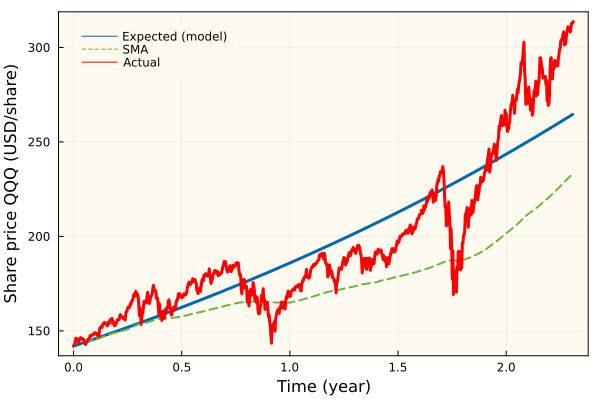

In [12]:
plot(expected_value_training_array[:,1], expected_value_training_array[:,2], label="Expected (model)", 
    legend=:topleft, lw=3, c=colorant"#0068AC", bg="floralwhite", background_color_outside="white", framestyle = :box, 
    fg_legend = :transparent)

plot!(actual_sma[:,1],actual_sma[:,2], label="SMA", ls=:dash,lw=2, c=colorant"#6EB43F")
plot!(T_all[training_range], df_training[:,:close], label="Actual", c=:red, lw=3)

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Share price QQQ (USD/share)", fontsize=18)

##### Estimate the volatility parameter $\sigma$ from the training data
To construct an estimate of the volatility parameter $\hat{\sigma}$ we try to match the model estimated variance:

$$\text{Var}\left(X_{t}\right) = X_{\circ}^{2}e^{2\mu{(t-t_{\circ})}}\left[e^{\sigma^{2}{(t-t_{\circ})}} - 1\right]$$

with the variance in the price data; where we let $\mu=\hat{\mu}$ and the variance $\text{Var}\left(X_{t}\right)$ is calculated by using the [implied volatility (IV)](https://www.investopedia.com/terms/i/iv.asp). The [implied volatility (IV)](https://www.investopedia.com/terms/i/iv.asp) gives the market estimate of the standard deviation of the price T-days in the future:

$$\sigma_{IV} = X_{\circ}\times\left(\frac{IV}{100}\right)\times\left(\sqrt{\frac{T}{365}}\right)$$

However, $\sigma^{2}_{IV}(t)\simeq{\text{Var}\left(X_{t}\right)}$; thus, we can solve the variance expression for $\sigma$:

$$\sigma^{2} = \frac{1}{T^{\prime}}\times\ln\left(\frac{\text{Var}\left(X_{T^{\prime}}\right)}{X_{\circ}^{2}e^{2\mu{T^{\prime}}}} + 1\right)$$

where:

$$T^{\prime} = \frac{1}{365}\left(T - T_{\circ}\right)$$

In [13]:
# update the model with a guess σ -

# Alternative approach: Estimate from the running average of the Var computed from data -
# training_model.σ = 0.105

# Implied volatility estimate of σ -
#IV = 27.0;  # historial IV for QQQ
#IV = 32.50;  # current IV for QQQ (10/5/22)
IV = 19.89; # HV for QQQ
Var_market = ((training_model.Xₒ)*(IV/100.0)*sqrt(ℒ/365))^2
T_market = (ℒ/365.0)
Xₒ = training_model.Xₒ
a = Var_market/((Xₒ^2)*exp(2*μ̂*T_market)) + 1
σ̂ = sqrt((1/T_market)*log(a))

# set the σ estimated from the implied volatility -
training_model.σ = σ̂

0.1058730377618234

Alternatively, we can fit a `LogNormal` distribution to the data, using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), and use the value of the estimated standard deviation to compute the variance, from which we can calculate the volatility parameter $\sigma$.

In [14]:
# estimate distribution -
d = fit_mle(LogNormal, df_training[:,:close]);

# show -
println("Estimated standard deviation: $(params(d)[2])")

Estimated standard deviation: 0.19890039033391


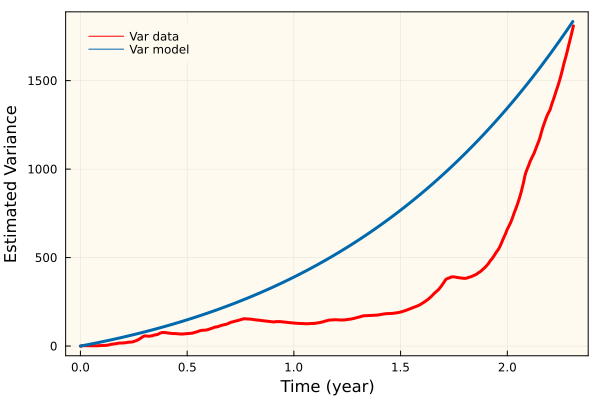

In [15]:
# check -
var_data = Var(df_training,:close; window=2000);
variance_training_model = Var(training_model)

plot(var_data[:,1], var_data[:,2],lw=3,c=:red, legend=:topleft, label="Var data", bg="floralwhite", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent)
plot!(variance_training_model[:,1], variance_training_model[:,2],lw=3, c=colorant"#0068AC", label="Var model")

# labels -
xlabel!("Time (year)", fontsize=18);
ylabel!("Estimated Variance", fontsize=18)

#### Check: In sample training model simulation

In [16]:
in_sample_simulation = solve(training_model);

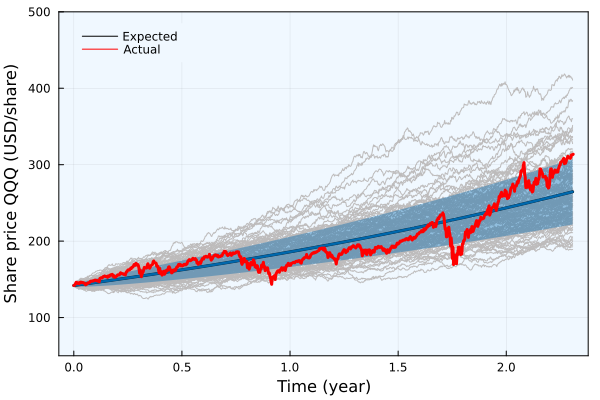

In [17]:
# setup bounds -
N_σ = 1.0
L = expected_value_training_array[:,2] .- N_σ*sqrt.(variance_training_model[:,2])
U = expected_value_training_array[:,2] .+ N_σ*sqrt.(variance_training_model[:,2])

# plot the in sample simulation -
plot(in_sample_simulation[:,1], in_sample_simulation[:,2:end], label="", c=colorant"#BDBBBB", legend=:topleft, bg="aliceblue", background_color_outside="white", framestyle = :box, fg_legend = :transparent, ylim=[50.0, 500.0]);
plot!(expected_value_training_array[:,1], expected_value_training_array[:,2],c=:black,lw=3,label="Expected")
plot!(expected_value_training_array[:,1], expected_value_training_array[:,2],c=colorant"#0068AC", fillrange=U, fillalpha = 0.4, lw=2, label="")
plot!(expected_value_training_array[:,1], expected_value_training_array[:,2],c=colorant"#0068AC", fillrange=L, fillalpha = 0.4, lw=2, label="")

# plot the data -
plot!(T_all[training_range],df_training[!,:close], lw=3, c=:red, label="Actual")

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Share price QQQ (USD/share)", fontsize=18)

#### c) Out of sample model prediction
Now that we have estimates of the drift and volatility parameters, let's see how the GBM model performs against data that was not used in training. For this, we build a prediction model and compare prediction model simulations against data in the `df_prediction` data set.

##### Build a prediction model instance

In [18]:
prediction_model = GeometricBrownianMotionModel()
prediction_model.μ = training_model.μ
prediction_model.σ = training_model.σ
prediction_model.T₁ = T_all[Int64(round(α*N))]
prediction_model.T₂ = T_all[end]
prediction_model.h = (1.0/365.0)
prediction_model.Xₒ = df_prediction[1,:close];

##### Prediction model simulations

In [19]:
out_sample_simulation = solve(prediction_model);

In [20]:
# compute the variance of the model -
variance_prediction_model = Var(prediction_model);

In [21]:
# compute the expectation -
expected_value_prediction_array = E(prediction_model);

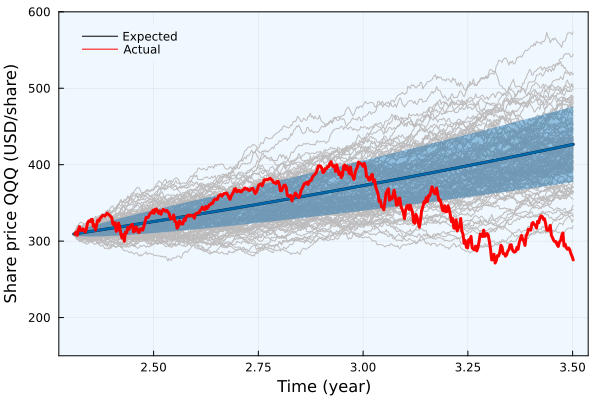

In [22]:
# setup bounds -
LP = expected_value_prediction_array[:,2] .- N_σ*sqrt.(variance_prediction_model[:,2])
UP = expected_value_prediction_array[:,2] .+ N_σ*sqrt.(variance_prediction_model[:,2])

# plot the in sample simulation -
plot(out_sample_simulation[:,1], out_sample_simulation[:,2:end], label="", c=colorant"#BDBBBB", legend=:topleft, bg="aliceblue", background_color_outside="white", framestyle = :box, fg_legend = :transparent, ylim=[150.0,600])
plot!(expected_value_prediction_array[:,1], expected_value_prediction_array[:,2],c=:black,lw=3, label="Expected")
plot!(expected_value_prediction_array[:,1], expected_value_prediction_array[:,2],c=colorant"#0068AC", fillrange=UP, fillalpha = 0.4, lw=2, label="")
plot!(expected_value_prediction_array[:,1], expected_value_prediction_array[:,2],c=colorant"#0068AC", fillrange=LP, fillalpha = 0.4, lw=2, label="")

# plot the data -
plot!(T_all[prediction_range],df_prediction[!,:close], lw=3, c=:red, label="Actual")

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Share price QQQ (USD/share)", fontsize=18)

### Some closing thoughts
In this lab, we demonstrated the calibration of a geometric Brownian motion model of the close price of QQQ using historical OHLC data. 

* The QQQ close price showed mean reversion behavior in the training data and through year 3 in the prediction, data set. Transient shifts ultimately settled back down to nominal behavior.
* Periods of economic or societal turmoil led to transient shifts in the nominal behavior of the QQQ share price, e.g., the 2018 trade crisis, the CoV19 pandemic starting in March 2020, or the current period of high inflation and rising interest rates (since approximately October 2021). 
* Could stochastic volatility or mean reversion price model better capture the short-term QQQ dynamics?

#### Terms
* [What is an ETF?](https://www.investopedia.com/terms/e/etf.asp)
* [What is the Nasdaq](https://www.nasdaq.com)

#### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.